<a href="https://colab.research.google.com/github/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/blob/main/notebooks/Human_Emotion_Detection_using_Resnet_Architecture_ipynbcture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Emotion Detection Using ResNet Architecture

## Overview of ResNet Architecture  

Residual Networks (ResNet) introduced the concept of *residual learning*, which revolutionized deep learning by addressing the challenges of training deep neural networks. As networks become deeper, they encounter issues such as vanishing gradients, which hinder effective learning. ResNet solves this problem by introducing **skip connections** (or residual connections) that allow the network to learn identity mappings. These connections "skip" one or more layers, making it easier for the optimizer to propagate gradients through the network.  

### Key Features of ResNet:  
1. **Residual Blocks**: The building block of ResNet consists of a shortcut connection that adds the input directly to the output of a set of convolutional layers.  
2. **Deeper Architectures**: ResNet architectures, such as ResNet-50 and ResNet-101, achieve state-of-the-art performance by enabling training of networks with hundreds or even thousands of layers.  
3. **Efficiency and Accuracy**: By learning residuals instead of the direct mapping, ResNet efficiently extracts features and minimizes training error.  

Below is an illustration of a residual block:  
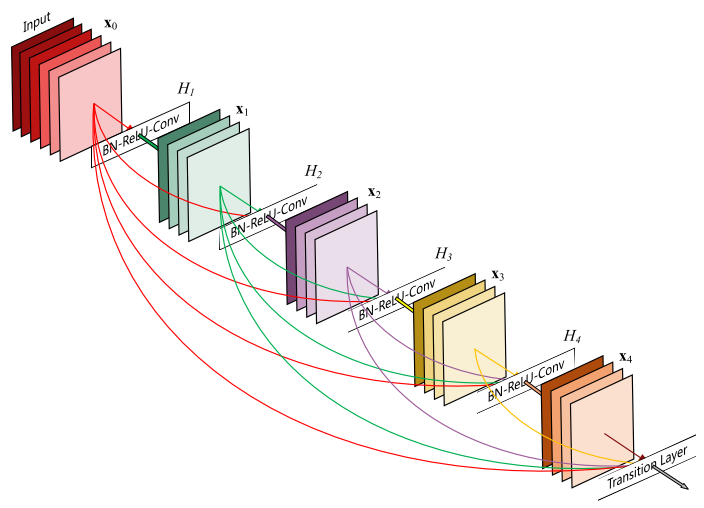
### Why Use ResNet for Human Emotion Detection?  
- **Deep Feature Learning**: Emotion detection requires extracting subtle facial features, which deeper networks like ResNet excel at capturing.  
- **Improved Performance**: Compared to traditional architectures like LeNet, ResNet provides significantly higher accuracy and robustness.  

In this notebook, we will leverage ResNet's architecture to classify emotions from facial images and compare its performance to the LeNet model used previously.


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
from tensorflow.keras.utils import plot_model
import io
from contextlib import redirect_stdout
import requests
from tensorflow.keras.saving import register_keras_serializable

In [31]:
!pip install -q kaggle

In [32]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [33]:
!chmod 600/root/.kaggle/kaggle.json

chmod: missing operand after ‘600/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [35]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/


mv: cannot move '/root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4' to '/content/4': Directory not empty


In [36]:
train_directory = "/content/4/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/4/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [37]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [38]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [39]:
training_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Explanation of the Code Implementation for ResNet34
===================================================

**1\. CustomConv2D Layer**
--------------------------

This is a custom convolutional layer that integrates two important operations: **Convolution** and **Batch Normalization**. Here's how it works:

### **Constructor (\_\_init\_\_)**:

*   **Parameters**:
    
    *   n\_filters: The number of filters (output channels) for the convolution.
        
    *   kernel\_size: The spatial size of the filter (e.g., 3×33 \\times 33×3 or 7×77 \\times 77×7).
        
    *   n\_strides: The stride of the convolution (how far the filter moves at each step).
        
    *   padding: Specifies whether the convolution is "same" (output size is preserved) or "valid" (output size is reduced).
        
*   **Initialization**:
    
    *   **Convolution**: A Conv2D layer is initialized with the specified filters, kernel size, strides, and padding.
        
    *   **Batch Normalization**: Normalizes the output of the convolution to stabilize training and improve performance.
        

### **Call Method (call)**:

*   Takes an input tensor x and performs:
    
    1.  **Convolution**: Extracts spatial features using the defined kernel.
        
    2.  **Batch Normalization**: Normalizes the feature maps for better training dynamics.
        
*   Returns the processed tensor.
    

**2\. ResidualBlock Layer**
---------------------------

This layer implements the **residual block**, a core component of ResNet that introduces **skip connections** to combat the vanishing gradient problem and improve gradient flow.

### **Constructor (\_\_init\_\_)**:

*   **Parameters**:
    
    *   n\_channels: The number of output channels for the block.
        
    *   n\_strides: The stride for the first convolution in the block (affects spatial size).
        
*   **Components**:
    
    *   **Two Convolutions**:
        
        *   First convolution: 3×33 \\times 33×3, with stride n\_strides.
            
        *   Second convolution: 3×33 \\times 33×3, with stride 1.
            
    *   **Optional 1×11 \\times 11×1 Convolution**:
        
        *   Used only when n\_strides != 1 (called "dotted skip connection").
            
        *   This matches the dimensions of the input to the residual block output.
            
    *   **Activation Function**: Applies ReLU to the final output.
        

### **Call Method (call)**:

*   **Input and Output Flow**:
    
    1.  Pass the input through the first and second convolutions.
        
    2.  Add the input (skip connection) to the output:
        
        *   If n\_strides = 1, add the raw input.
            
        *   If n\_strides != 1, process the input through a 1×11 \\times 11×1 convolution before adding it.
            
    3.  Apply ReLU to the final result.
        

### **Why Skip Connections?**

*   They allow the network to learn identity mappings, helping prevent performance degradation as the network deepens.
    

**3\. ResNet34 Model**
----------------------

The ResNet34 implementation follows the ResNet architecture, stacking multiple residual blocks in a structured manner. Here's how it is built:

### **Constructor (\_\_init\_\_)**:

*   **Components**:
    
    1.  **Initial Convolution**:
        
        *   7×77 \\times 77×7 convolution with stride 2 and 64 filters.
            
        *   Reduces spatial dimensions while extracting features.
            
    2.  **Max Pooling**:
        
        *   3×33 \\times 33×3 pooling with stride 2, further reducing spatial dimensions.
            
    3.  **Residual Blocks**:
        
        *   Divided into **five stages**, each with a different number of residual blocks and feature dimensions:
            
            *   **Stage 2**: 3 blocks with 64 channels.
                
            *   **Stage 3**: 4 blocks with 128 channels, downsampled using stride 2.
                
            *   **Stage 4**: 6 blocks with 256 channels, downsampled using stride 2.
                
            *   **Stage 5**: 3 blocks with 512 channels, downsampled using stride 2.
                
    4.  **Global Average Pooling**:
        
        *   Reduces the spatial dimensions to 1x1 by averaging across the spatial dimensions, outputting a feature vector.
            
    5.  **Fully Connected Layer**:
        
        *   Outputs predictions for the number of classes specified by CONFIGURATION\["NUM\_CLASSES"\] using softmax activation.
            

### **Call Method (call)**:

*   **Forward Pass**:
    
    1.  **Initial Processing**:
        
        *   Input is passed through the initial 7×77 \\times 77×7 convolution and max pooling.
            
    2.  **Residual Stages**:
        
        *   Each stage processes the feature map using its residual blocks, progressively increasing depth and decreasing spatial size.
            
    3.  **Global Pooling**:
        
        *   The final feature map is averaged spatially to produce a 1D vector.
            
    4.  **Classification**:
        
        *   The vector is passed through the dense layer to produce class probabilities.
            

**How the Components Work Together**
------------------------------------

### **Step-by-Step Input Flow** (Example Input: 224×224×3224 \\times 224 \\times 3224×224×3):

1.  **Initial Convolution**:
    
    *   224×224→112×112224 \\times 224 \\to 112 \\times 112224×224→112×112 (stride 2, padding "same").
        
    *   Outputs 64 feature maps.
        
2.  **Max Pooling**:
    
    *   112×112→56×56112 \\times 112 \\to 56 \\times 56112×112→56×56 (stride 2).
        
3.  **Residual Stages**:
    
    *   **Stage 2**: Maintains spatial size 56×5656 \\times 5656×56, outputs 64 channels.
        
    *   **Stage 3**: Downsamples to 28×2828 \\times 2828×28, outputs 128 channels.
        
    *   **Stage 4**: Downsamples to 14×1414 \\times 1414×14, outputs 256 channels.
        
    *   **Stage 5**: Downsamples to 7×77 \\times 77×7, outputs 512 channels.
        
4.  **Global Pooling**:
    
    *   Converts 7×7×512→1×5127 \\times 7 \\times 512 \\to 1 \\times 5127×7×512→1×512.
        
5.  **Dense Layer**:
    
    *   Outputs class probabilities (e.g., for 100010001000 classes in ImageNet).
        

**Details on Specific Concepts**
--------------------------------

### **1\. Role of 1×11 \\times 11×1 Convolution**

*   Used in residual blocks with stride 2 to:
    
    1.  Downsample the spatial dimensions to match the main branch.
        
    2.  Ensure the number of channels in the input matches the output.
        

### **2\. Benefits of Batch Normalization**

*   Helps stabilize training by normalizing feature maps.
    
*   Reduces the need for careful weight initialization.
    

### **3\. Skip Connections in Residual Blocks**

*   Allow the network to learn residual functions, improving gradient flow.
    
*   Mitigate vanishing gradients, enabling deeper networks to perform well.
    

### **4\. Global Average Pooling**

*   Simplifies the network by replacing fully connected layers with spatial averaging.
    
*   Reduces the number of parameters, preventing overfitting.
    

**Summary of the Network's Role**
---------------------------------

*   **ResNet34**: A 34-layer network designed to extract hierarchical features while maintaining training stability and accuracy through residual connections. It is suitable for image classification tasks, especially on large datasets like ImageNet.
    


In [40]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training =training)

    return x

In [41]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training=True):

    x = self.custom_conv_1(input, training =training)
    x = self.custom_conv_2(x, training =training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training =training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


**Detailed Explanation of Skip Connections in Residual Blocks**
===============================================================

**What Are Skip Connections?**
------------------------------

Skip connections, also known as **identity shortcuts**, are a key component of residual blocks in ResNet. These connections **bypass one or more layers** in the network, allowing the input of a block to be added directly to its output. This creates a pathway for gradients to flow backward during training, which helps prevent the **vanishing gradient problem**.

**How Skip Connections Are Made**
---------------------------------

In the residual block implementation, the skip connection is created by either:

1.  **Directly Adding the Input**:If the dimensions of the input and output match, the input is directly added to the output of the block.
    
2.  **Adding a Transformed Input**:If the dimensions of the input and output do not match (e.g., when downsampling), the input is transformed using a **1×11 \\times 11×1** convolution with the required stride. This ensures that:
    
    *   The **spatial dimensions** of the input match those of the block's output.
        
    *   The **number of channels** matches between the input and the output.
        

### **Implementation in Code**

1.  pythonCopier le codex\_add = Add()(\[x, input\])
    
    *   The output x from the convolutions is added directly to the input.
        
    *   This is used when n\_strides = 1, and no dimension change is required.
        
2.  pythonCopier le codex\_add = self.custom\_conv\_3(input, training)x\_add = Add()(\[x, x\_add\])
    
    *   The input is passed through a 1×11 \\times 11×1 convolution with stride nnn, reducing its spatial size and/or changing its channel dimensions to match the block's output.
        
    *   The transformed input is then added to the output of the block.
        

**Potential Information Loss in Skip Connections**
--------------------------------------------------

### **1\. Direct Skip Connections**

*   **Scenario**: No transformation of the input (identity connection).
    
*   **Loss of Information**: Minimal to none, as the raw input is preserved and added to the output.
    
*   **Reason**: Since the dimensions of the input and output are the same, no spatial or channel-level changes occur.
    

### **2\. Skip Connections with 1×11 \\times 11×1 Convolution**

*   **Scenario**: Input is passed through a 1×11 \\times 11×1 convolution to match the output's dimensions.
    
*   **Loss of Information**: Can occur due to:
    
    *   **Dimensionality Reduction**:
        
        *   1×11 \\times 11×1 convolutions with fewer output channels reduce the feature map's channel dimensions, potentially discarding information.
            
    *   **Strided Convolution**:
        
        *   Using a stride of 222 reduces the spatial dimensions, causing downsampling and loss of fine-grained spatial details.
            
    *   **Kernel Size**:
        
        *   The 1×11 \\times 11×1 kernel does not capture spatial relationships beyond individual pixels, which may limit its ability to fully preserve structural information.
            

**Trade-Offs in Skip Connections**
----------------------------------

*   **Advantages**:
    
    1.  **Gradient Flow**:
        
        *   Skip connections ensure that gradients can flow directly to earlier layers, improving the training of deep networks.
            
    2.  **Identity Mapping**:
        
        *   They enable the network to learn residual functions (i.e., changes from the input), which is often easier than learning full mappings.
            
    3.  **Stability**:
        
        *   Skip connections reduce the risk of degradation in deep networks, where adding more layers can lead to worse performance without them.
            
*   **Disadvantages**:
    
    1.  **Information Loss**:
        
        *   When 1×11 \\times 11×1 convolutions downsample the input, some information (spatial or channel-wise) may be lost, especially fine details.
            
    2.  **Bias Toward Low-Level Features**:
        
        *   By passing low-level features directly to later layers, the network may overemphasize them, potentially affecting high-level feature extraction.
            

**Why Skip Connections Work Despite Information Loss**
------------------------------------------------------

Skip connections are highly effective even with minor information loss because:

1.  **Compensation by Deeper Layers**:Deeper layers can learn to reintroduce or reconstruct lost information using the output of preceding layers.
    
2.  **Focus on Residual Learning**:The network focuses on learning the **difference** between the input and output, rather than the entire mapping, making it robust to small losses.
    
3.  **Preservation of Key Features**:Even with 1×11 \\times 11×1 convolutions, essential features are often retained, ensuring the main structure of the input is preserved.
    

**Summary**
-----------

*   Skip connections play a critical role in stabilizing deep networks and improving performance.
    
*   Information loss can occur when using 1×11 \\times 11×1 convolutions with strides for downsampling, but the benefits of improved gradient flow and residual learning outweigh this drawback in practice.

In [51]:
@register_keras_serializable(package='Custom', name='ResNet34')
class ResNet34(Model):
  def __init__(self, num_classes=1000, **kwargs):
    super(ResNet34, self).__init__(name = 'resnet_34')
    self.num_classes = num_classes

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training =training)
    x = self.conv_2_2(x, training =training)
    x = self.conv_2_3(x, training =training)

    x = self.conv_3_1(x, training =training)
    x = self.conv_3_2(x, training =training)
    x = self.conv_3_3(x, training =training)
    x = self.conv_3_4(x, training =training)

    x = self.conv_4_1(x, training =training)
    x = self.conv_4_2(x, training =training)
    x = self.conv_4_3(x, training =training)
    x = self.conv_4_4(x, training =training)
    x = self.conv_4_5(x, training =training)
    x = self.conv_4_6(x, training =training)

    x = self.conv_5_1(x, training =training)
    x = self.conv_5_2(x, training =training)
    x = self.conv_5_3(x, training =training)

    x = self.global_pool(x)

    return self.fc_3(x)
  def get_config(self):
        # Return configuration for serialization
        config = super(ResNet34, self).get_config()
        config.update({"num_classes": self.num_classes})
        return config

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [52]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (1, 63, 63, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (1, 512)                    │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Training :

In [53]:
# Checkpoint to save the model
model_dir = "/content/models/ResNet-34"
os.makedirs(model_dir, exist_ok=True)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "resnet_34.keras"),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [54]:
loss_function = CategoricalCrossentropy()

In [55]:
metrics = [CategoricalAccuracy(name = "accuracy") , TopKCategoricalAccuracy(k=2 , name = "top_k_accuracy")]

In [56]:
resnet_34.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [57]:
def upload_to_github_release(repo_name, token, tag, file_path, release_name="Model Release"):
    """
    Pushes a file to a GitHub Release.
    Arguments:
        repo_name (str): Repository name in the format "username/repo".
        token (str): GitHub Fine-Grained Personal Access Token.
        tag (str): Release tag (e.g., "v1.0").
        file_path (str): Path to the file to upload.
        release_name (str): Name of the release.
    """
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/vnd.github+json",
    }
    # Step 1: Create a release
    release_url = f"https://api.github.com/repos/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/releases"
    release_data = {"tag_name": tag, "name": release_name, "draft": False, "prerelease": False}
    response = requests.post(release_url, headers=headers, json=release_data)
    if response.status_code != 201:
        print("Failed to create release:", response.json())
        return

    release_id = response.json()["id"]
    upload_url = response.json()["upload_url"].split("{")[0]

    # Step 2: Upload the file
    file_name = os.path.basename(file_path)
    with open(file_path, "rb") as f:
        upload_response = requests.post(
            f"{upload_url}?name={file_name}",
            headers=headers,
            files={"file": (file_name, f)},
        )
    if upload_response.status_code == 201:
        print("File successfully uploaded to GitHub Release!")
    else:
        print("Failed to upload file:", upload_response.json())

history = resnet_34.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"]*3 , verbose = 1,callbacks=[checkpoint])

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 120ms/step - accuracy: 0.4442 - loss: 1.5219 - top_k_accuracy: 0.7615 - val_accuracy: 0.3178 - val_loss: 6.8485 - val_top_k_accuracy: 0.6356
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5185 - loss: 1.0220 - top_k_accuracy: 0.7904 - val_accuracy: 0.4715 - val_loss: 1.2673 - val_top_k_accuracy: 0.7919
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5505 - loss: 0.9806 - top_k_accuracy: 0.8130 - val_accuracy: 0.5584 - val_loss: 0.9235 - val_top_k_accuracy: 0.8306
Epoch 4/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6014 - loss: 0.8726 - top_k_accuracy: 0.8471 - val_accuracy: 0.5465 - val_loss: 1.1787 - val_top_k_accuracy: 0.8332
Epoch 5/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6468 - loss: 0.8014 - top_k_accuracy: 0.8787 - val_accuracy: 0.5781 - val_loss: 1.0532 - val_top_k_accuracy: 0.8398
Epoch 6/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.6790 - loss:

In [65]:
model_path = os.path.join(model_dir, "resnet_34.keras")
github_repo = "Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision"  # Replace with your repo
github_token =  # Replace with your Fine-Grained Token
release_tag = "v4.0"  # Specify your release tag
upload_to_github_release(github_repo, github_token, release_tag, model_path , release_name = "Human Emotion Detection-ResNet-34 Architecture Model Release")


File successfully uploaded to GitHub Release!


In [58]:
import pickle
import os

# Directory to save the history
history_dir = "/content/models/ResNet-34/history"
os.makedirs(history_dir, exist_ok=True)

# Saving the history object as a pickle file
history_path = os.path.join(history_dir, "training_history.pkl")

# Assuming 'history' is the training history from lenet_model.fit
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"Training history saved at {history_path}")


Training history saved at /content/models/ResNet-34/history/training_history.pkl


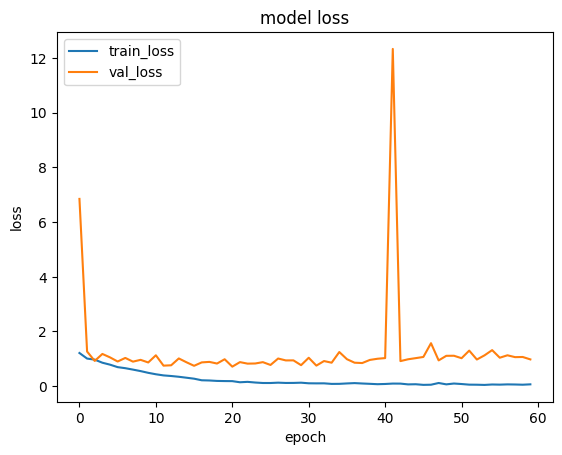

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

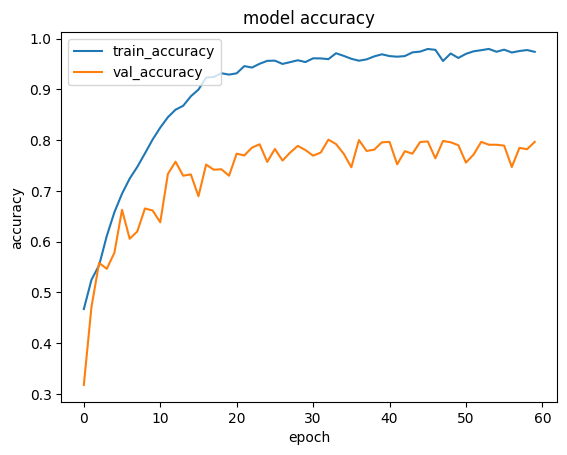

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

## Evaluation


In [61]:
import json

# Evaluate the model
evaluation_results = resnet_34.evaluate(validation_dataset)

# Create a dictionary of metric names and values
results_dict = dict(zip(resnet_34.metrics_names, evaluation_results))

# Save to a JSON file
with open("evaluation_results.json", "w") as file:
    json.dump(results_dict, file, indent=4)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7879 - loss: 1.0012 - top_k_accuracy: 0.9375


In [62]:
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = "/content/models/ResNet-34/resnet_34.keras"

# Load the model
resnet_34 = load_model(model_path)



In [63]:
evaluation_results = resnet_34.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7844 - loss: 1.0199 - top_k_accuracy: 0.9165


In [64]:
test_image = cv2.imread("/content/4/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")
im = tf.constant(test_image , dtype = tf.float32)
im = tf.expand_dims(im , axis = 0)
print(resnet_34(im))
print(CLASS_NAMES[tf.argmax(resnet_34(im) , axis = 1).numpy()[0]])

tf.Tensor([[0.14763853 0.75668055 0.09568096]], shape=(1, 3), dtype=float32)
happy


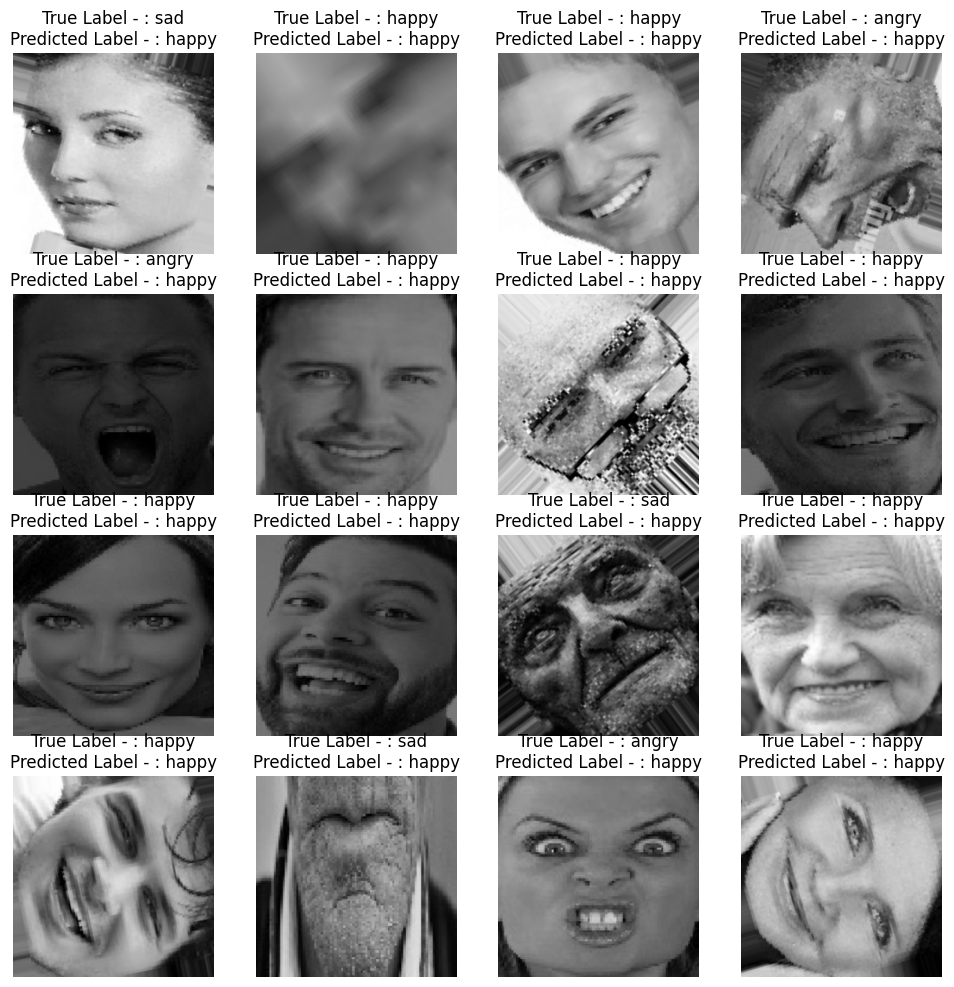

In [66]:
plt.figure(figsize = (12,12))

for images , labels in val_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i] , axis = 0).numpy()] + "\n" + "Predicted Label - : " + CLASS_NAMES[tf.argmax(resnet_34(tf.expand_dims(images[i],axis=0)) , axis = 1).numpy()[0]])
    plt.axis("off")

In [67]:
predicted = []
labels = []
for im , label in val_dataset :
  predicted.append(resnet_34(im))
  labels.append(label.numpy())

In [68]:
print(np.concatenate([np.argmax(labels[:-1] , axis =-1).flatten(),np.argmax(labels[-1] , axis =-1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1] , axis =-1).flatten(),np.argmax(predicted[-1] , axis =-1).flatten()]))

[1 1 2 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [69]:
pred = np.argmax(predicted[:-1] , axis =-1).flatten()
label = np.argmax(labels[:-1] , axis =-1).flatten()

[[382  55  77]
 [ 49 877  76]
 [ 88  95 573]]


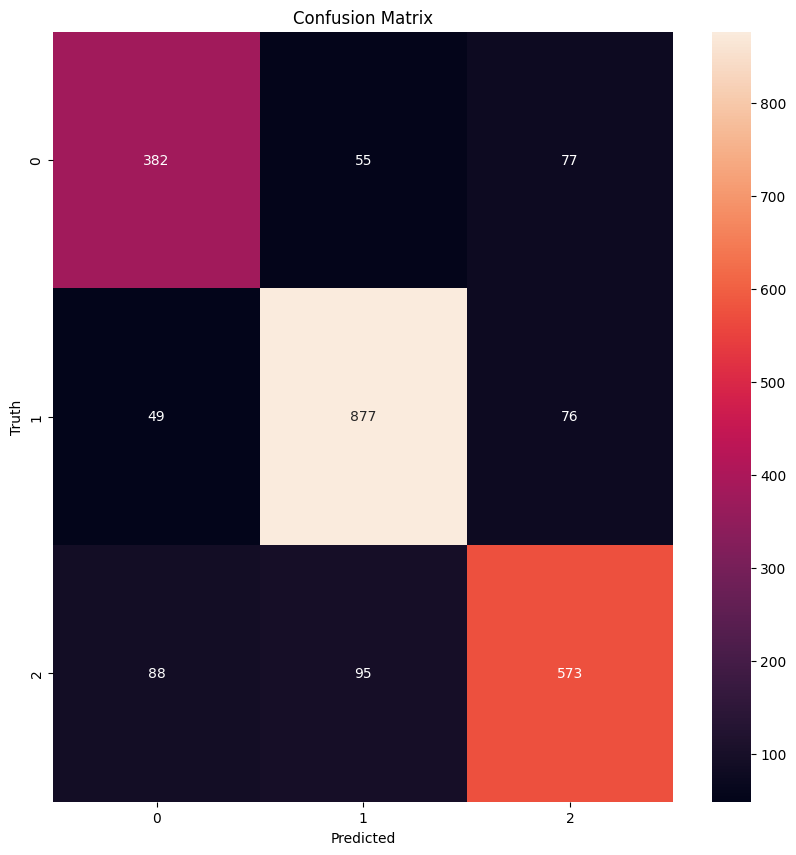

In [70]:
cm = confusion_matrix(label , pred)
print(cm)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")
plt.show()

In [71]:
import pickle
import os

# Directory to save the confusion matrix
cm_dir = "./models/ResNet-34/confusion_matrix"
os.makedirs(cm_dir, exist_ok=True)

# Path to save the confusion matrix
cm_path = os.path.join(cm_dir, "confusion_matrix.pkl")

# Save the confusion matrix as a pickle file
with open(cm_path, "wb") as f:
    pickle.dump(cm, f)

print(f"Confusion matrix saved at {cm_path}")


Confusion matrix saved at ./models/LeNet-5/confusion_matrix/confusion_matrix.pkl
